# ResNet-50 in PyTorch

This notebook is an implementation of the coursework from the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) in CNNs - Week 2. 

The objective is replicate the identity and convolutional blocks to then implement the ResNet-50 in `Pytorch` instead of `Tensorflow` as seen in the coursework.

* Adapted from: Deep Learning Specialization by Andrew Ng, Coursera
  
  Source: Course Assignment - [Convolutional Neural Networks], Week 2
  
  URL: https://www.coursera.org/specializations/deep-learning

  Retrieved: October 2025
  

## Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

## 1. Identity Block

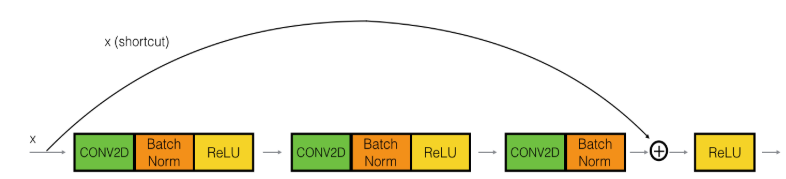
<caption><center> </u><font color='black'> <b>Identity block structure</center></caption>

* The identity block is composed of:

  * Main Path:
    1. CONV2D - BatchNorm - ReLU
    2. CONV2D - BatchNorm - ReLU
    3. CONV2D - BatchNorm

  * Shortcut:
 
    The output of the 3rd layer of the main path is added to the original input.
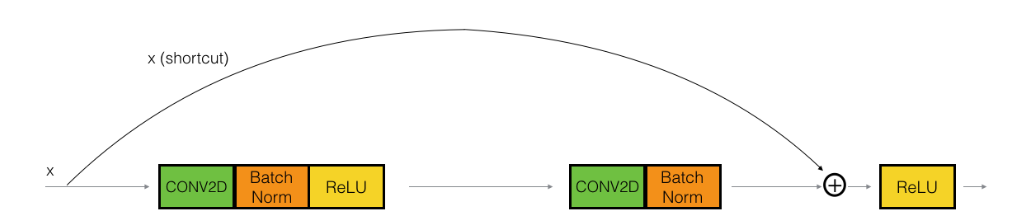

In [3]:
# Set up the random uniform initializer for the conv layers that works similar
# to TensorFlow's random_uniform initializer
def random_uniform_initializer(tensor, a=-0.05, b=0.05, seed=0):
    torch.manual_seed(seed)
    return nn.init.uniform_(tensor, a=a, b=b)
    
# Indentity Block Class:
class IdentityBlock(nn.Module):
    def __init__(self, in_channels, f, filters, initializer=random_uniform_initializer):
        super(IdentityBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, stride=1, padding=f//2) # 'same' padding
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)
        self.relu_output = nn.ReLU(inplace=True)

        # Apply random uniform initializer to all conv layers
        initializer(self.conv1.weight)
        initializer(self.conv2.weight)
        initializer(self.conv3.weight)

    def forward(self, X):
        X_shortcut = X

        # First component of main path
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu1(X)

        # Second component of main path
        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu2(X)

        # Third component of main path
        X = self.conv3(X)
        X = self.bn3(X)

        # Add shortcut and final activation
        X = X + X_shortcut
        X = self.relu_output(X)

        return X

## 2. Convolutional Block

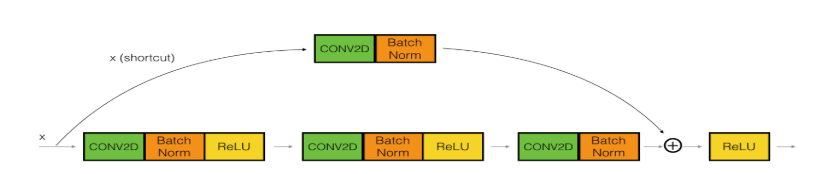
<caption><center> </u><font color='black'> <b>Convolutional block structure</center></caption>

* The identity block is composed of:

  * Main Path:
    1. CONV2D - BatchNorm - ReLU
    2. CONV2D - BatchNorm - ReLU
    3. CONV2D - BatchNorm

  * Shortcut:
 
    CONV2D - BatchNorm

In [4]:
# Set up glorot uniform initializer for the conv layers 
def glorot_uniform_initializer(tensor, seed=0):
    torch.manual_seed(seed)
    nn.init.xavier_uniform_(tensor)
    
# Convolutional Block Class:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, f, filters, s=2, initializer=glorot_uniform_initializer):
        super(ConvBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=s, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=f, stride=1, padding=f//2) # 'same' padding
        self.bn2 = nn.BatchNorm2d(F2)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)

        self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, stride=s, padding=0)
        self.bn_shortcut = nn.BatchNorm2d(F3)
        self.relu_output = nn.ReLU(inplace=True)

        # Apply glorot uniform initializer to all conv layers
        initializer(self.conv1.weight)
        initializer(self.conv2.weight)
        initializer(self.conv3.weight)
        initializer(self.conv_shortcut.weight)

    def forward(self, X):
        X_shortcut = X

        # First component of main path
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu1(X)
        
        # Second component of main path
        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu2(X)

        # Third component of main path
        X = self.conv3(X)
        X = self.bn3(X)

        # Shortcut convolution and final activation
        X_shortcut = self.conv_shortcut(X_shortcut)
        X_shortcut = self.bn_shortcut(X_shortcut)
        X = X + X_shortcut
        X = self.relu_output(X)

        return X

## 3. RestNet-50 Model

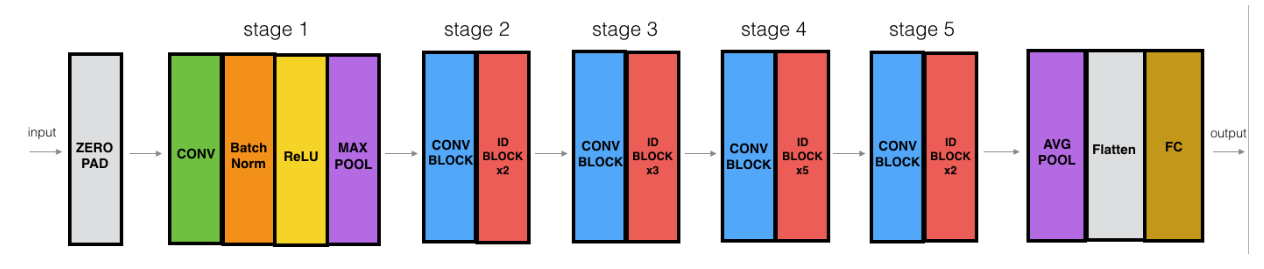

<caption><center> </u><font color='black'> <b>ResNet-50 structure</center></caption>


In [5]:
class ResNet50(nn.Module):
    def __init__(self, input_shape=(3, 64, 64), classes=6, initializer=glorot_uniform_initializer):
        super(ResNet50, self).__init__()
        # Stage 1
        self.pad = nn.ConstantPad2d(3, 0)  # ZeroPadding2D((3, 3))
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=7, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        # Stage 2
        self.stage2_0 = ConvBlock(64, f=3, filters=[64, 64, 256], s=1)
        self.stage2_1 = IdentityBlock(256, f=3, filters=[64, 64, 256])
        self.stage2_2 = IdentityBlock(256, f=3, filters=[64, 64, 256])

        # Stage 3
        self.stage3_0 = ConvBlock(256, f=3, filters=[128, 128, 512], s=2)
        self.stage3_1 = IdentityBlock(512, f=3, filters=[128, 128, 512])
        self.stage3_2 = IdentityBlock(512, f=3, filters=[128, 128, 512])
        self.stage3_3 = IdentityBlock(512, f=3, filters=[128, 128, 512])

        # Stage 4
        self.stage4_0 = ConvBlock(512, f=3, filters=[256, 256, 1024], s=2)
        self.stage4_1 = IdentityBlock(1024, f=3, filters=[256, 256, 1024])
        self.stage4_2 = IdentityBlock(1024, f=3, filters=[256, 256, 1024])
        self.stage4_3 = IdentityBlock(1024, f=3, filters=[256, 256, 1024])
        self.stage4_4 = IdentityBlock(1024, f=3, filters=[256, 256, 1024])
        self.stage4_5 = IdentityBlock(1024, f=3, filters=[256, 256, 1024])

        # Stage 5
        self.stage5_0 = ConvBlock(1024, f=3, filters=[512, 512, 2048], s=2)
        self.stage5_1 = IdentityBlock(2048, f=3, filters=[512, 512, 2048])
        self.stage5_2 = IdentityBlock(2048, f=3, filters=[512, 512, 2048])

        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048 * 1 * 1, classes)

        # Apply glorot uniform initializer to Stage 1 and FC layer
        initializer(self.conv1.weight)
        initializer(self.fc.weight)

    def forward(self, x):
        # Stage 1
        x = self.pad(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Stage 2
        x = self.stage2_0(x)
        x = self.stage2_1(x)
        x = self.stage2_2(x)

        # Stage 3
        x = self.stage3_0(x)
        x = self.stage3_1(x)
        x = self.stage3_2(x)
        x = self.stage3_3(x)

        # Stage 4
        x = self.stage4_0(x)
        x = self.stage4_1(x)
        x = self.stage4_2(x)
        x = self.stage4_3(x)
        x = self.stage4_4(x)
        x = self.stage4_5(x)

        # Stage 5
        x = self.stage5_0(x)
        x = self.stage5_1(x)
        x = self.stage5_2(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        # x = F.softmax(x, dim=1) this is commented because i'll use nn.CrossEntropyLoss() later
        return x

## 4. Train the model

To train/test the model I'll use the [Dogs vs. Cats Dataset](https://www.kaggle.com/competitions/dogs-vs-cats), that contains 25,000 labeled images of cats and dogs

### Data Preprocessing

Extract the zip file that contains the pictures for training:

In [6]:
import os
import zipfile

# Extract the zip file of training
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

print(len(os.listdir('/kaggle/working/train')))
print(os.listdir('/kaggle/working/train')[:10])

1
['train']


Set up the root direction:

In [7]:
root_dir_train = '/kaggle/working/train/train'
root_dir_test = '/kaggle/working/test/test1'
print(len(os.listdir(root_dir_train)))           # Should be 25000
print(os.listdir(root_dir_train)[:10])
print(len(os.listdir(root_dir_test)))

25000
['cat.12465.jpg', 'cat.2213.jpg', 'dog.6621.jpg', 'cat.6384.jpg', 'dog.1802.jpg', 'dog.10395.jpg', 'cat.10192.jpg', 'cat.2785.jpg', 'dog.12275.jpg', 'cat.10199.jpg']
12500


In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        label = 0 if img_name.startswith('cat') else 1  # 0: cat, 1: dog
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms (match ResNet50 input size and normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset_train = CatsDogsDataset(root_dir_train, transform=transform)
dataset_test = CatsDogsDataset(root_dir_test, transform=transform)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)


### Training and Validation Loops

In [9]:
model = ResNet50()
# Optimizer and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
criterion = nn.CrossEntropyLoss()

In [10]:
n_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()                     # Clear previous gradients
        outputs = model(images)                   # Forward pass
        loss = criterion(outputs, labels)         # Compute Loss
        loss.backward()                           # Backward pass
        optimizer.step()                          # Update Parameters
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Loss: 0.8269, Train Acc: 0.5862 | Val Loss: 0.6536, Val Acc: 0.5822
Epoch 2/10 | Train Loss: 0.6410, Train Acc: 0.6806 | Val Loss: 0.8400, Val Acc: 0.4682
Epoch 3/10 | Train Loss: 0.6423, Train Acc: 0.6885 | Val Loss: 3.1436, Val Acc: 0.4276
Epoch 4/10 | Train Loss: 0.6844, Train Acc: 0.6310 | Val Loss: 1.1909, Val Acc: 0.7518
Epoch 5/10 | Train Loss: 0.7074, Train Acc: 0.5918 | Val Loss: 1.4006, Val Acc: 0.3266
Epoch 6/10 | Train Loss: 0.6468, Train Acc: 0.6611 | Val Loss: 0.8908, Val Acc: 0.3811
Epoch 7/10 | Train Loss: 0.5976, Train Acc: 0.6922 | Val Loss: 0.8657, Val Acc: 0.4823
Epoch 8/10 | Train Loss: 0.6264, Train Acc: 0.6703 | Val Loss: 0.7110, Val Acc: 0.5012
Epoch 9/10 | Train Loss: 0.6082, Train Acc: 0.6926 | Val Loss: 1.2402, Val Acc: 0.4586
Epoch 10/10 | Train Loss: 0.5465, Train Acc: 0.7315 | Val Loss: 0.8926, Val Acc: 0.5192


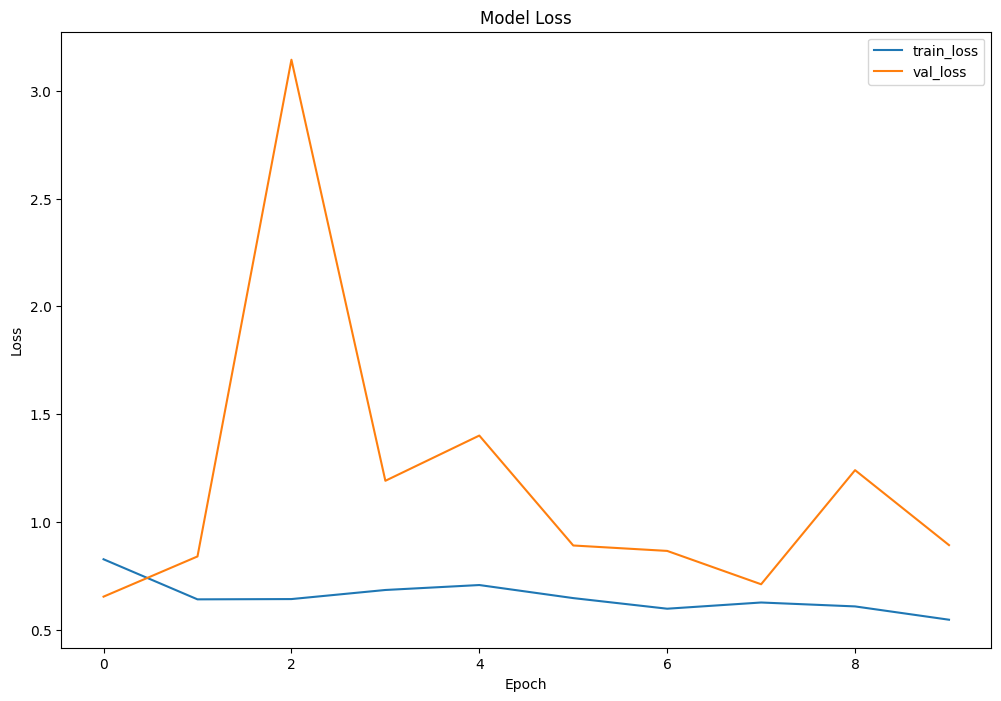

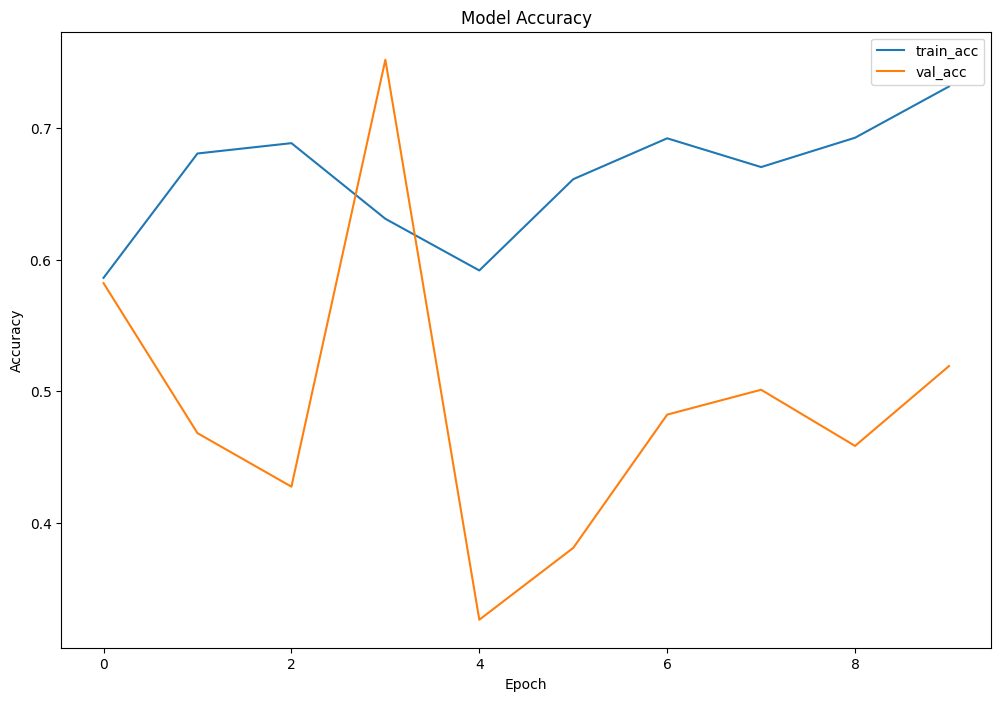

In [11]:
# Plotting Loss/Accuracy:
df_metrics = pd.DataFrame({
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accuracies,
    'val_acc': val_accuracies
})

# Loss
df_metrics[['train_loss', 'val_loss']].plot(title='Model Loss', figsize=(12,8)).set(xlabel='Epoch', ylabel='Loss')
plt.show()

# Accuracy
df_metrics[['train_acc', 'val_acc']].plot(title='Model Accuracy', figsize=(12,8)).set(xlabel='Epoch', ylabel='Accuracy')
plt.show()

## Conclusions

As we can see, the performance of the model is pretty poor and with a lot of fluctuation, but the pourpose of this little application was to get a functional ResNet in Pytorch.

* To power up the performance we could run the ResNet for a longer time, as this result came from running only for 10 epochs (roughly 10 minutes, I wanted to save the free Kaggle's GPU for bigger projects).
* Other possible thing to do would be tweak the hyperparameters and/or layers structure, as I exactly implemented the same worked in [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning), from **Keras** to **Torch**.